<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/solar_p2h2p_gasifier_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRE-RUN

In [2]:
from IPython.display import clear_output
!pip install pymoo
!pip install brewer2mpl
!pip install matplotlib
clear_output()

In [14]:
import matplotlib.pyplot as plt
# Set the global font and text parameters for plots
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 16
plt.rcParams['text.color'] = 'black'

# Function to set the plot style
def set_plot_style(ax):
    # Set the border color to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
# Set linewidth for spines
    ax.spines['top'].set_linewidth(1.3)
    ax.spines['bottom'].set_linewidth(1.3)
    ax.spines['left'].set_linewidth(1.3)
    ax.spines['right'].set_linewidth(1.3)

    # Set tick color and width
    ax.tick_params(axis='both', direction='in', width=1.5, colors='black')

In [4]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:100]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

hydrogen_sp = 3 #usd/kg
'''
    Calculating the Annualized system cost(ASC) and the levelised cost of energy(LCOE)
'''
def cost_electrolyser(electrolyser, electrolyser_elec):
  electrolyser_cap = ((585.85+(9458.2/electrolyser)*electrolyser**0.622)*((2024/2020)**(-158.9)))
  electrolyser_elec_op = electrolyser_elec*0.04*CRF
  electrolyser_op = 0.04*CRF*electrolyser_cap + electrolyser_elec_op
  electrolyser_cost = CRF*electrolyser_cap+electrolyser_op
  return electrolyser_cost

def cost_tank(tank):
  tank_cap = tank*350
  tank_op = tank_cap*CRF*0.01
  tank_cost = CRF*tank_cap + tank_op
  return tank_cost

def cost_fuelcell(fuellcell):
  fuellcell_cap = fuellcell*1600
  fuellcell_op = fuellcell_cap*CRF*0.04
  fuellcell_cost = CRF*fuellcell_cap + fuellcell_op
  return fuellcell_cost

def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  # print(solar_cost)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  # print(gasifier_cost)
  return gasifier_cost

def LCOE(total_energy_prod, total_hydrogen_prod, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_electrolyser(electrolyser, electrolyser_elec)+cost_tank(tank)+cost_fuelcell(fuelcell)
  energy_prod_per_year = total_energy_prod/N
  hydrogen_prod_per_year = total_hydrogen_prod/N
  annualized_hydrogen_rev = hydrogen_prod_per_year*hydrogen_sp
  lcoe = (ASC-annualized_hydrogen_rev)/(energy_prod_per_year)
  return ASC, lcoe

def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

def fuel_cell_energy(fuellcell, hydrogen_lev):
  'maximum energy produced by fuelcell'
  rated_hr_energy = fuellcell
  rated_h2_consumption = rated_hr_energy/(33.33*0.4)
  if rated_h2_consumption>hydrogen_lev:
    energy_output = rated_hr_energy*(hydrogen_lev/rated_h2_consumption)
  else:
    energy_output = rated_hr_energy

  return energy_output

def electrolyser_hydrogen(electrolyser, energy):
  h2_prod_rated = electrolyser*0.7/39.4
  h2_made = 0
  if energy >= electrolyser:
      h2_made = h2_prod_rated
  else:
      h2_made = (energy/electrolyser)*h2_prod_rated
  return h2_made

def fuel_cell_h2_used(energy, fuellcell):
  rated_h2_consumed = fuellcell/(33.33*0.4)
  if energy==fuellcell:
    h2_consumed = rated_h2_consumed
  else:
    h2_consumed = (energy*rated_h2_consumed)/fuellcell
  return h2_consumed
'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, tank_lev, tank_max, electrolyser, fuelcell,  solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  tank_lev_up = tank_lev
  fuelcell_supply = 0
  hydrogen_excess = 0
  electrolyser_ene = 0


  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)
  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run fuelcell and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and fuelcell
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if tank_lev>0:
        if req_energy<=(fuel_cell_energy(fuelcell, tank_lev)):
          '''
          req_energy met by only fuelcell
          '''
          fuelcell_supply = req_energy
          energy_served+=fuelcell_supply
          tank_lev_up = tank_lev-fuel_cell_h2_used(req_energy, fuelcell)

        else:
          '''
          req_energy met by fuelcell and gasifier
          '''
          gasifier_E_req = req_energy-(fuel_cell_energy(fuelcell, tank_lev))
          fuelcell_supply = fuel_cell_energy(fuelcell, tank_lev)
          energy_served+=fuelcell_supply
          tank_lev_up = tank_lev-fuel_cell_h2_used(fuelcell_supply, fuelcell)
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            pass
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            # print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          pass
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          # print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")
    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used in electrolyser for hydrogen production.
      '''
      energy_served+=energy_def  # solar panel served the entire deficit energy
      Ech_t = solar_energy-energy_def  # extra energy from solar used for electrolyser
      h2_made = electrolyser_hydrogen(electrolyser, Ech_t)

      if h2_made<=tank_max-tank_lev:
        tank_lev_up = tank_lev+h2_made

      else:
        tank_lev_up = tank_max
        hydrogen_excess = h2_made - (tank_max-tank_lev)

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy #solar energy already calculated outside loop
    surplus_ene = abs(energy_def)#make hydrogen from this

    Ech_t = 0
    if solar_energy>=electrolyser:
      Ech_t = solar_energy
    else:
      if surplus_ene+solar_energy<electrolyser:
        Ech_t = surplus_ene+solar_energy
        electrolyser_ene = surplus_ene
      else:
        Ech_t = electrolyser
        electrolyser_ene = electrolyser-solar_energy

    h2_made = electrolyser_hydrogen(electrolyser, Ech_t)

    if h2_made<=tank_max-tank_lev:
      tank_lev_up = tank_lev+h2_made

    else:
      tank_lev_up = tank_max
      hydrogen_excess = h2_made - (tank_max-tank_lev)

  return energy_served, fuelcell_supply, tank_lev_up, electrolyser_ene, solar_energy, gasifier_energy, hydrogen_excess

'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      # print(design)
      solar, gasifier, electrolyser, tank, fuelcell = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      tank_lev = 0
      electrolyser_elec = 0
      hydrogen_tot = 0

      for i in range(len(df)):
        Energy_served ,fuelcell_supply, tank_lev, electrolyser_ene, solar_ene, gasifier_ene, hydrogen_sold = Energy_prod_(energy_def=df['deficit_energy'][i] , tank_lev=tank_lev ,tank_max=tank, electrolyser=electrolyser, fuelcell=fuelcell, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        electrolyser_elec+=electrolyser_ene
        hydrogen_tot+=hydrogen_sold
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1
          break

      asc, lcoe = LCOE(Energy_prod_N, hydrogen_tot, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=5, n_obj=1, n_eq_constr=1, xl=[0,  0, 0, 0, 0], xu=[7440937, 2360000, 5469333, 293000, 1302164],vtype=int)
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
algorithm = GA(pop_size=2,
               sampling=IntegerRandomSampling(),
               crossover=SBX(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               mutation=PM(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 5)
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   verbose=True,
                   seed=42,
                   save_history=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |        2 |  0.000000E+00 |  0.000000E+00 |  7.273492E+02 |  6.608724E+02
     2 |        4 |  0.000000E+00 |  0.000000E+00 |  6.234632E+02 |  5.860539E+02
     3 |        6 |  0.000000E+00 |  0.000000E+00 |  5.502410E+02 |  5.153132E+02
     4 |        8 |  0.000000E+00 |  0.000000E+00 |  5.153132E+02 |  5.153132E+02
     5 |       10 |  0.000000E+00 |  0.000000E+00 |  4.762249E+02 |  4.371365E+02


In [5]:
inv_cost_unit = 300 # usd/kW(capex)
inv_OM = 1 # usd/kW.year(opex)
# inv_cap = np.array(solar_ene_array).max()
def cost_inv(inv):
  inv_cost = inv*((CRF*inv_cost_unit)+inv_OM)
  return inv_cost

N=20
def LCOE_inv(total_energy_prod, inv_cap):
  ASC_inv = cost_inv(inv_cap)
  energy_prod_per_year = total_energy_prod/N
  lcoe_inv = ASC_inv/(energy_prod_per_year)
  return lcoe_inv

#POST OPTIMIZATION

In [8]:
import pickle
with open('pv-gas-P2H2P_new_ga-res.pkl', 'rb') as file:
    results_p2h2p = pickle.load(file)

df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:24*365*20]
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [9]:
def analyse_func(results):
    solar, gasifier, electrolyser, tank, fuelcell  = results.X

    solar_array = []
    gasifier_array = []
    fuelcell_array = []
    tank_array = []
    deficit_array = []

    total_supply = []


    count = 0
    Energy_prod_N = 0 #total energy throughout the project life produced
    tank_lev = 0
    gasifier_up_hr = 0
    gasifier_energy = 0
    electrolyser_elec = 0
    hydrogen_tot = 0

    for i in range(len(df)):
    # for i in range(8760):
      Energy_served ,fuelcell_supply, tank_lev, electrolyser_ene, solar_ene, gasifier_ene, hydrogen_sold = Energy_prod_(energy_def=df['deficit_energy'][i] , tank_lev=tank_lev ,tank_max=tank, electrolyser=electrolyser, fuelcell=fuelcell, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
      electrolyser_elec+=electrolyser_ene
      hydrogen_tot+=hydrogen_sold
      Energy_prod_N += Energy_served
      gasifier_energy+=gasifier_ene

      if round(gasifier_ene, 2)>0:
        # print(gasifier_ene)
        # print(i)


        gasifier_up_hr+=1
      deficit_array.append(df['deficit_energy'][i])
      solar_array.append(solar_ene)
      gasifier_array.append(gasifier_ene)
      fuelcell_array.append(fuelcell_supply)
      tank_array.append(tank_lev)
      total_supply.append(fuelcell_supply+gasifier_ene+solar_ene)

    asc, lcoe = LCOE(Energy_prod_N, hydrogen_tot, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell)
    ene_tot_p2h2p = Energy_prod_N
    return hydrogen_tot
    # print(asc, lcoe)
    # print(hydrogen_tot)
    # print(gasifier_up_hr)
    # print(gasifier_energy)

In [10]:
analyse_func(results_p2h2p)

4766903379.544106

In [11]:
solar, gasifier, electrolyser, tank, fuelcell  = results_p2h2p.X

solar_array = []
gasifier_array = []
fuelcell_array = []
tank_array = []
deficit_array = []

total_supply = []


count = 0
Energy_prod_N = 0 #total energy throughout the project life produced
tank_lev = 0
gasifier_up_hr = 0
gasifier_energy = 0
electrolyser_elec = 0
hydrogen_tot = 0

for i in range(len(df)):
# for i in range(8760):
  Energy_served ,fuelcell_supply, tank_lev, electrolyser_ene, solar_ene, gasifier_ene, hydrogen_sold = Energy_prod_(energy_def=df['deficit_energy'][i] , tank_lev=tank_lev ,tank_max=tank, electrolyser=electrolyser, fuelcell=fuelcell, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  electrolyser_elec+=electrolyser_ene
  hydrogen_tot+=hydrogen_sold
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene

  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  fuelcell_array.append(fuelcell_supply)
  tank_array.append(tank_lev)
  total_supply.append(fuelcell_supply+gasifier_ene+solar_ene)

asc, lcoe = LCOE(Energy_prod_N, hydrogen_tot, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell)
ene_tot_p2h2p = Energy_prod_N
print(asc, lcoe)
print(hydrogen_tot)
print(gasifier_up_hr)
print(gasifier_energy)

1151973535.7711394 0.5343330628822829
4766903379.544106
32526
7881004306.902808


In [12]:
yearly_solar = []
yearly_gasifier = []
yearly_fc = []
gasifier_n = 0
solar_n = 0
fc_n = 0
for i in range(len(df)):
  Energy_served ,fuelcell_supply, tank_lev, electrolyser_ene, solar_ene, gasifier_ene, hydrogen_sold = Energy_prod_(energy_def=df['deficit_energy'][i] , tank_lev=tank_lev ,tank_max=tank, electrolyser=electrolyser, fuelcell=fuelcell, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  electrolyser_elec+=electrolyser_ene
  hydrogen_tot+=hydrogen_sold
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene

  gasifier_n += gasifier_ene
  fc_n += fuelcell_supply
  if df['deficit_energy'][i]<0:
    solar_n += -df['deficit_energy'][i]-fuelcell_supply-gasifier_ene
  else:
    solar_n += 0

  if i%8760==0 or i==175199:
    yearly_solar.append(solar_n)
    yearly_gasifier.append(gasifier_n)
    yearly_fc.append(fc_n)

    solar_n = 0
    gasifier_n = 0
    fc_n = 0


  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  fuelcell_array.append(fuelcell_supply)
  tank_array.append(tank_lev)
  total_supply.append(fuelcell_supply+gasifier_ene+solar_ene)
yearly_solar = yearly_solar[1:]
yearly_gasifier = yearly_gasifier[1:]
yearly_fc = yearly_fc[1:]

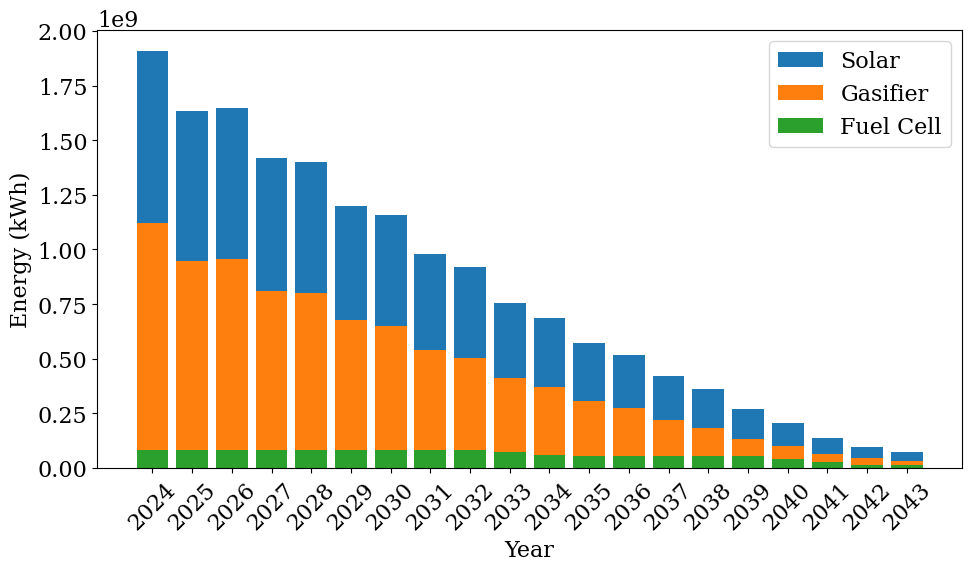

In [19]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create the stacked bar chart
plt.bar(range(len(yearly_solar)), yearly_solar, label='Solar', bottom=[sum(x) for x in zip([0]*len(yearly_solar),yearly_gasifier, yearly_fc)])
plt.bar(range(len(yearly_gasifier)), yearly_gasifier, label='Gasifier', bottom=yearly_fc)
plt.bar(range(len(yearly_fc)), yearly_fc, label='Fuel Cell')

plt.xlabel("Year")
plt.ylabel("Energy (kWh)")
plt.legend()
# plt.legend(prop={'size': 18})

# Set xticks to years 2024-2043 and rotate them
plt.xticks(range(len(yearly_solar)), [str(i + 2024) for i in range(len(yearly_solar))], rotation=45)

plt.tight_layout()
plt.savefig('energy_fc.png', dpi=600)
plt.show()

In [ ]:
inv_cap_p2h2p = np.array(solar_array).max()
inv_p2h2p_lcoe = LCOE_inv(ene_tot_p2h2p, inv_cap_p2h2p)
inv_p2h2p_lcoe

0.2213652429003677

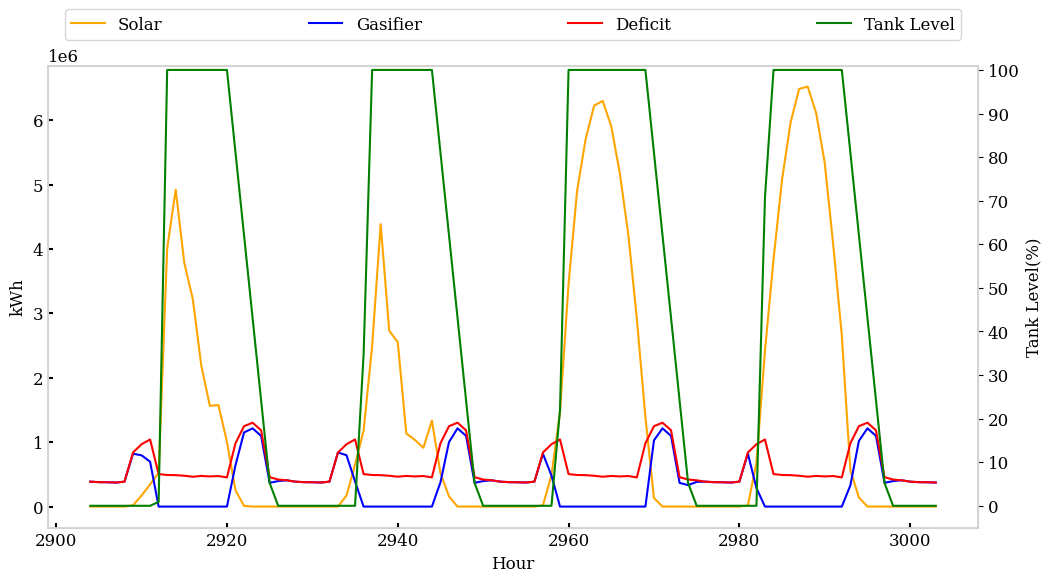

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

'''
Viewing the operation of the optimized hybrid energy system.
'''
# plt.figure(figsize=(12, 6))
i = 2904 # start hour
j = 2904+100 # end hour
x = np.arange(i,j)

# plt.figure(figsize=(10,8), dpi=500)
# plt.subplot(1,1,1)


fig, ax1 = plt.subplots(figsize=(12, 6))
set_plot_style(plt.gca())
# ax = plt.gca()  # Get the current axes
ax1.spines['top'].set_color('lightgray')
ax1.spines['bottom'].set_color('lightgray')
ax1.spines['left'].set_color('lightgray')
ax1.spines['right'].set_color('lightgray')

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')
# ax1.plot(x, battery_array[i:j], label='battery-SOC', color='green')
ax1.plot(x, -np.array(deficit_array[i:j]), label='Deficit', color='red')
ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.grid(axis='x', linestyle='--', alpha=0.7)


# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Normalize battery array to 0-1 range
# normalized_battery = (np.array(battery_array[i:j]) - np.min(battery_array[i:j])) / (np.max(battery_array[i:j]) - np.min(battery_array[i:j]))
normalized_tank =  100*(np.array(tank_array[i:j]) - np.min(tank_array[i:j])) / (np.max(tank_array[i:j]) - np.min(tank_array[i:j]))

# ax = plt.gca()  # Get the current axes
ax2.spines['top'].set_color('lightgray')
ax2.spines['bottom'].set_color('lightgray')
ax2.spines['left'].set_color('lightgray')
ax2.spines['right'].set_color('lightgray')

# Plotting on the second y-axis (right)
ax2.plot(x, normalized_tank, label='Tank Level', color='green')
ax2.set_ylabel("Tank Level(%)")
# ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(bottom=None, top=101) # Set the limit of the second y-axis
ax2.set_yticks(np.arange(0.0, 110, 10))


# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=1.)
plt.savefig("FC-operation.png", dpi=600)
plt.show()

In [ ]:
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p.X
# asc pie chart
solar_asc = cost_pv(solar_p2h2p)
gasifier_asc = cost_gasifier(gasifier_p2h2p)
inv_p2h2p_asc = cost_inv(inv_cap_p2h2p)
elec_asc = cost_electrolyser(electrolyser, electrolyser_elec)
fc_asc = cost_fuelcell(fuelcell)
tank_asc = cost_tank(tank)

<Figure size 5000x4000 with 0 Axes>

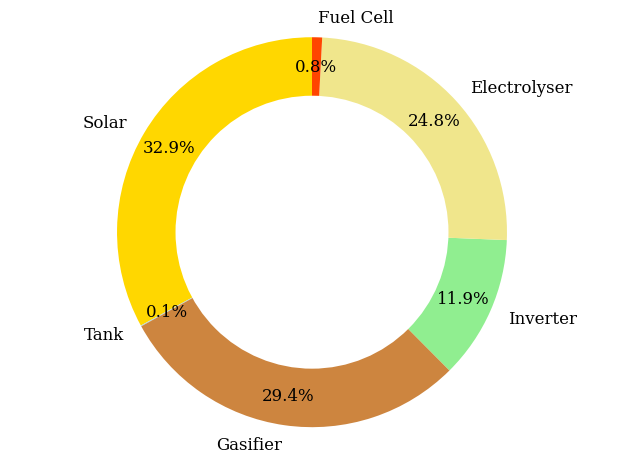

In [ ]:
# Data for the pie chart
labels = ['Solar', 'Tank', 'Gasifier', 'Inverter', 'Electrolyser', 'Fuel Cell' ]
sizes = [solar_asc, tank_asc, gasifier_asc, inv_p2h2p_asc, elec_asc, fc_asc]
colors = ['gold', 'lightblue', 'peru', 'lightgreen', 'khaki', 'orangered']

# Create the pie chart with a hole in the middle
plt.figure(figsize=(10,8), dpi=500)
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the middle to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
# plt.title('Annualized System Cost Components')
plt.tight_layout()
plt.savefig('p2h2p_ASC.png', dpi=600)
plt.show()

In [ ]:
results_p2h2p.F+inv_p2h2p_lcoe

array([0.72182959])

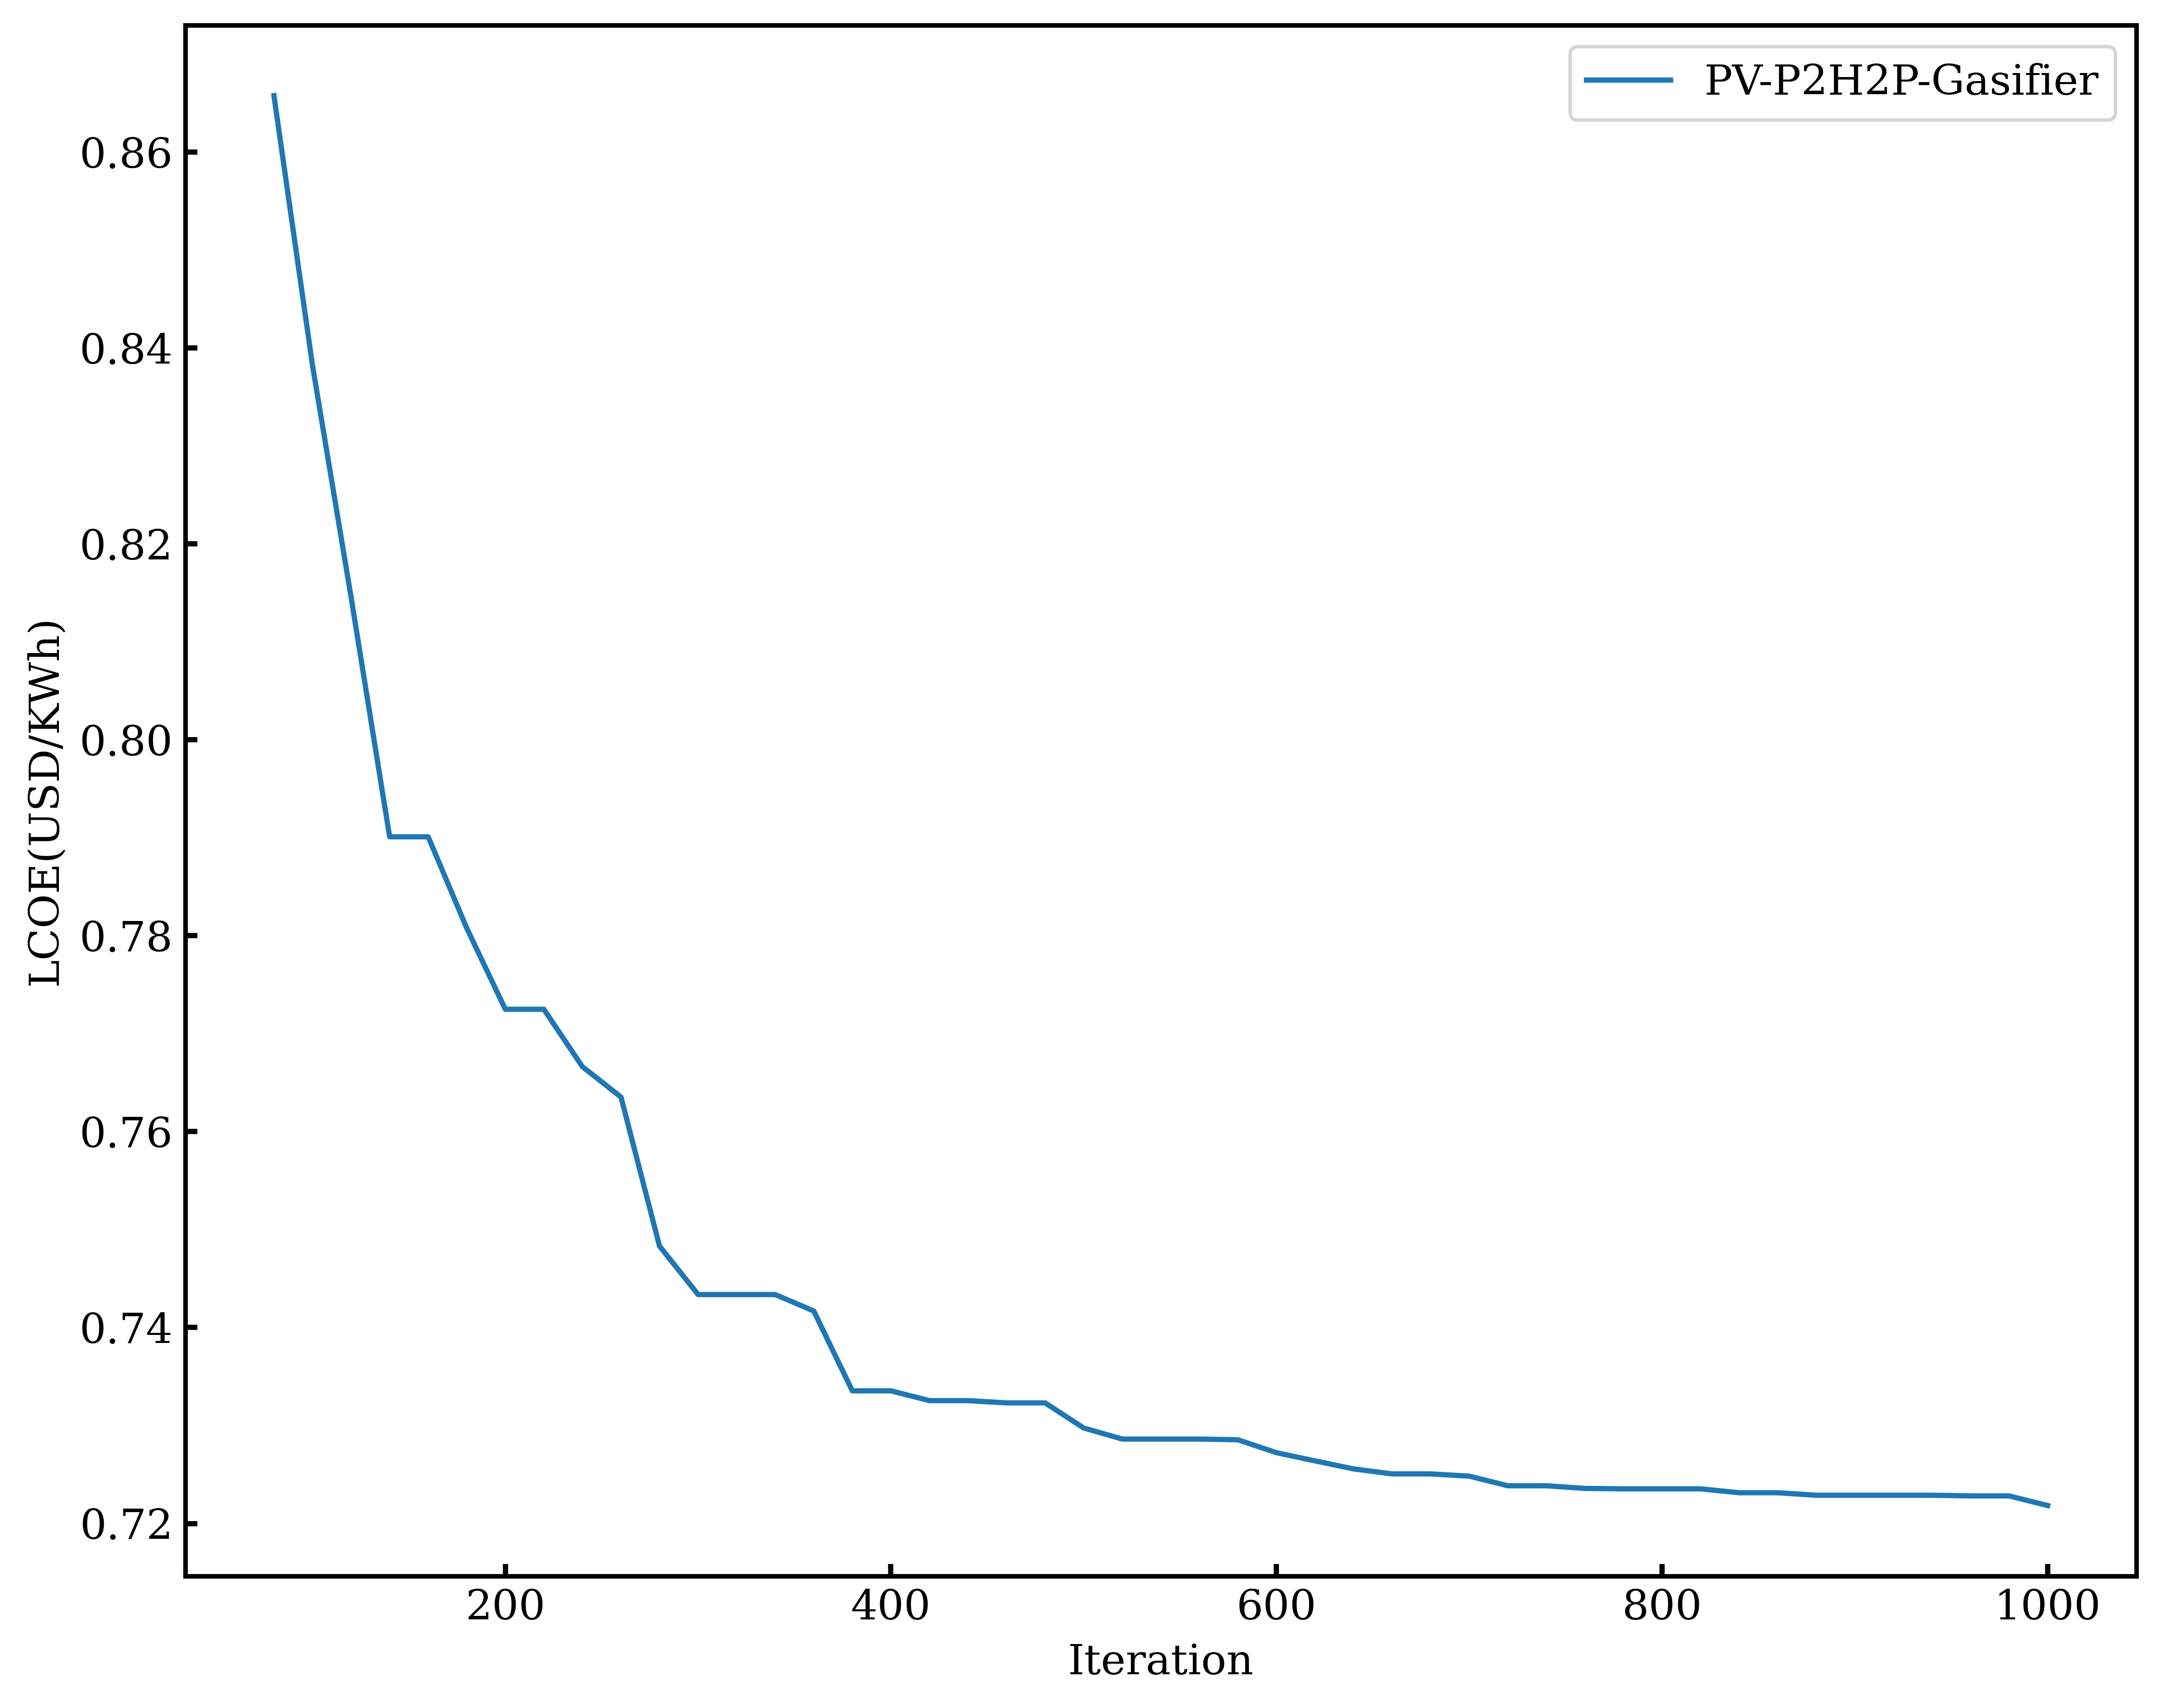

In [ ]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

# plt.title("Convergence")
plt.figure(figsize=(10,8), dpi=500)
plt.subplot(1,1,1)
set_plot_style(plt.gca())

# n_evals = np.array([e.evaluator.n_eval for e in results_phs.history])
# opt = np.array([e.opt[0].F for e in results_phs.history])
# plt.plot(n_evals[3:], opt[3:]+inv_phs_lcoe, label = "PV-PHS-Gasifier", linestyle="-")

n_evals = np.array([e.evaluator.n_eval for e in results_p2h2p.history])
opt = np.array([e.opt[0].F for e in results_p2h2p.history])
plt.plot(n_evals[3:], opt[3:]+inv_p2h2p_lcoe, label = "PV-P2H2P-Gasifier", linestyle="-")

# n_evals = np.array([e.evaluator.n_eval for e in results_bat.history])
# opt = np.array([e.opt[0].F for e in results_bat.history])
# plt.plot(n_evals[3:], opt[3:]+inv_bat_lcoe,label = "PV-Battery-Gasifier", linestyle="-")


plt.xlabel("Iteration")
plt.ylabel("LCOE(USD/KWh)")
plt.legend(loc='upper right')
# plt.savefig('phs_convergence.png')
# plt.savefig('battery_convergence.png')
plt.savefig('p2h2p_convergence_3USD_kg.png')
plt.show()

# SENSITIVITY

In [ ]:
# with open('pv-gas-P2H2P_new_ga-res_1$.pkl', 'rb') as file:
#     results_p2h2p1 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_2$.pkl', 'rb') as file:
    results_p2h2p2 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_2.25$.pkl', 'rb') as file:
    results_p2h2p2_25 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_2.50$.pkl', 'rb') as file:
    results_p2h2p2_50 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_2.75$.pkl', 'rb') as file:
    results_p2h2p2_75 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res.pkl', 'rb') as file:
    results_p2h2p3 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_3.25$.pkl', 'rb') as file:
    results_p2h2p3_25 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_3.50$.pkl', 'rb') as file:
    results_p2h2p3_50 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_3.75$.pkl', 'rb') as file:
    results_p2h2p3_75 = pickle.load(file)

with open('pv-gas-P2H2P_new_ga-res_4$.pkl', 'rb') as file:
    results_p2h2p4 = pickle.load(file)

# with open('pv-gas-P2H2P_new_ga-res_5$.pkl', 'rb') as file:
#     results_p2h2p5 = pickle.load(file)

In [ ]:
# solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p1.X
# print(f"1$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p1.F+inv_p2h2p_lcoe}USD/KWh")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p2.X
print(f"2$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p2.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p2)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p2_25.X
print(f"2_25$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p2_25.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p2_25)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p2_50.X
print(f"2_50$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p2_50.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p2_50)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p2_75.X
print(f"2_75$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p2_75.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p2_75)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p3.X
print(f"3$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p3.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p3)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p3_25.X
print(f"3_25$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p3_25.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p3_25)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p3_50.X
print(f"3_50$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p3_50.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p3_50)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p3_75.X
print(f"3_75$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p3_75.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p3_75)}")
solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p4.X
print(f"4$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p4.F+inv_p2h2p_lcoe}USD/KWh, Total_H2:{analyse_func(results_p2h2p4)}")
# solar_p2h2p, gasifier_p2h2p, electrolyser, tank, fuelcell = results_p2h2p5.X
# print(f"5$/kg=Solar:{solar_p2h2p}KW, Gasifier: {gasifier_p2h2p}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results_p2h2p5.F+inv_p2h2p_lcoe}USD/KWh")


2$/kg=Solar:2837801KW, Gasifier: 2190049KW, Electrolyser: 2003262KW, Tank: 38546Kg, Fuelcell: 98059 || LCOE: [0.96240728]USD/KWh, Total_H2:2250323075.580242
2_25$/kg=Solar:2366243KW, Gasifier: 2251393KW, Electrolyser: 1652635KW, Tank: 32397Kg, Fuelcell: 64424 || LCOE: [0.92830542]USD/KWh, Total_H2:1999375905.5995874
2_50$/kg=Solar:6942846KW, Gasifier: 2118422KW, Electrolyser: 5451130KW, Tank: 53657Kg, Fuelcell: 137767 || LCOE: [0.86725851]USD/KWh, Total_H2:4492157047.083652
2_75$/kg=Solar:7311549KW, Gasifier: 2348878KW, Electrolyser: 5465813KW, Tank: 3980Kg, Fuelcell: 10294 || LCOE: [0.80342535]USD/KWh, Total_H2:4794120621.809878
3$/kg=Solar:7440518KW, Gasifier: 2212477KW, Electrolyser: 5468875KW, Tank: 34575Kg, Fuelcell: 87371 || LCOE: [0.72182959]USD/KWh, Total_H2:4766903379.544106
3_25$/kg=Solar:7440853KW, Gasifier: 2342131KW, Electrolyser: 5469304KW, Tank: 5518Kg, Fuelcell: 14191 || LCOE: [0.64716617]USD/KWh, Total_H2:4845969627.866532
3_50$/kg=Solar:7429712KW, Gasifier: 2244610KW,

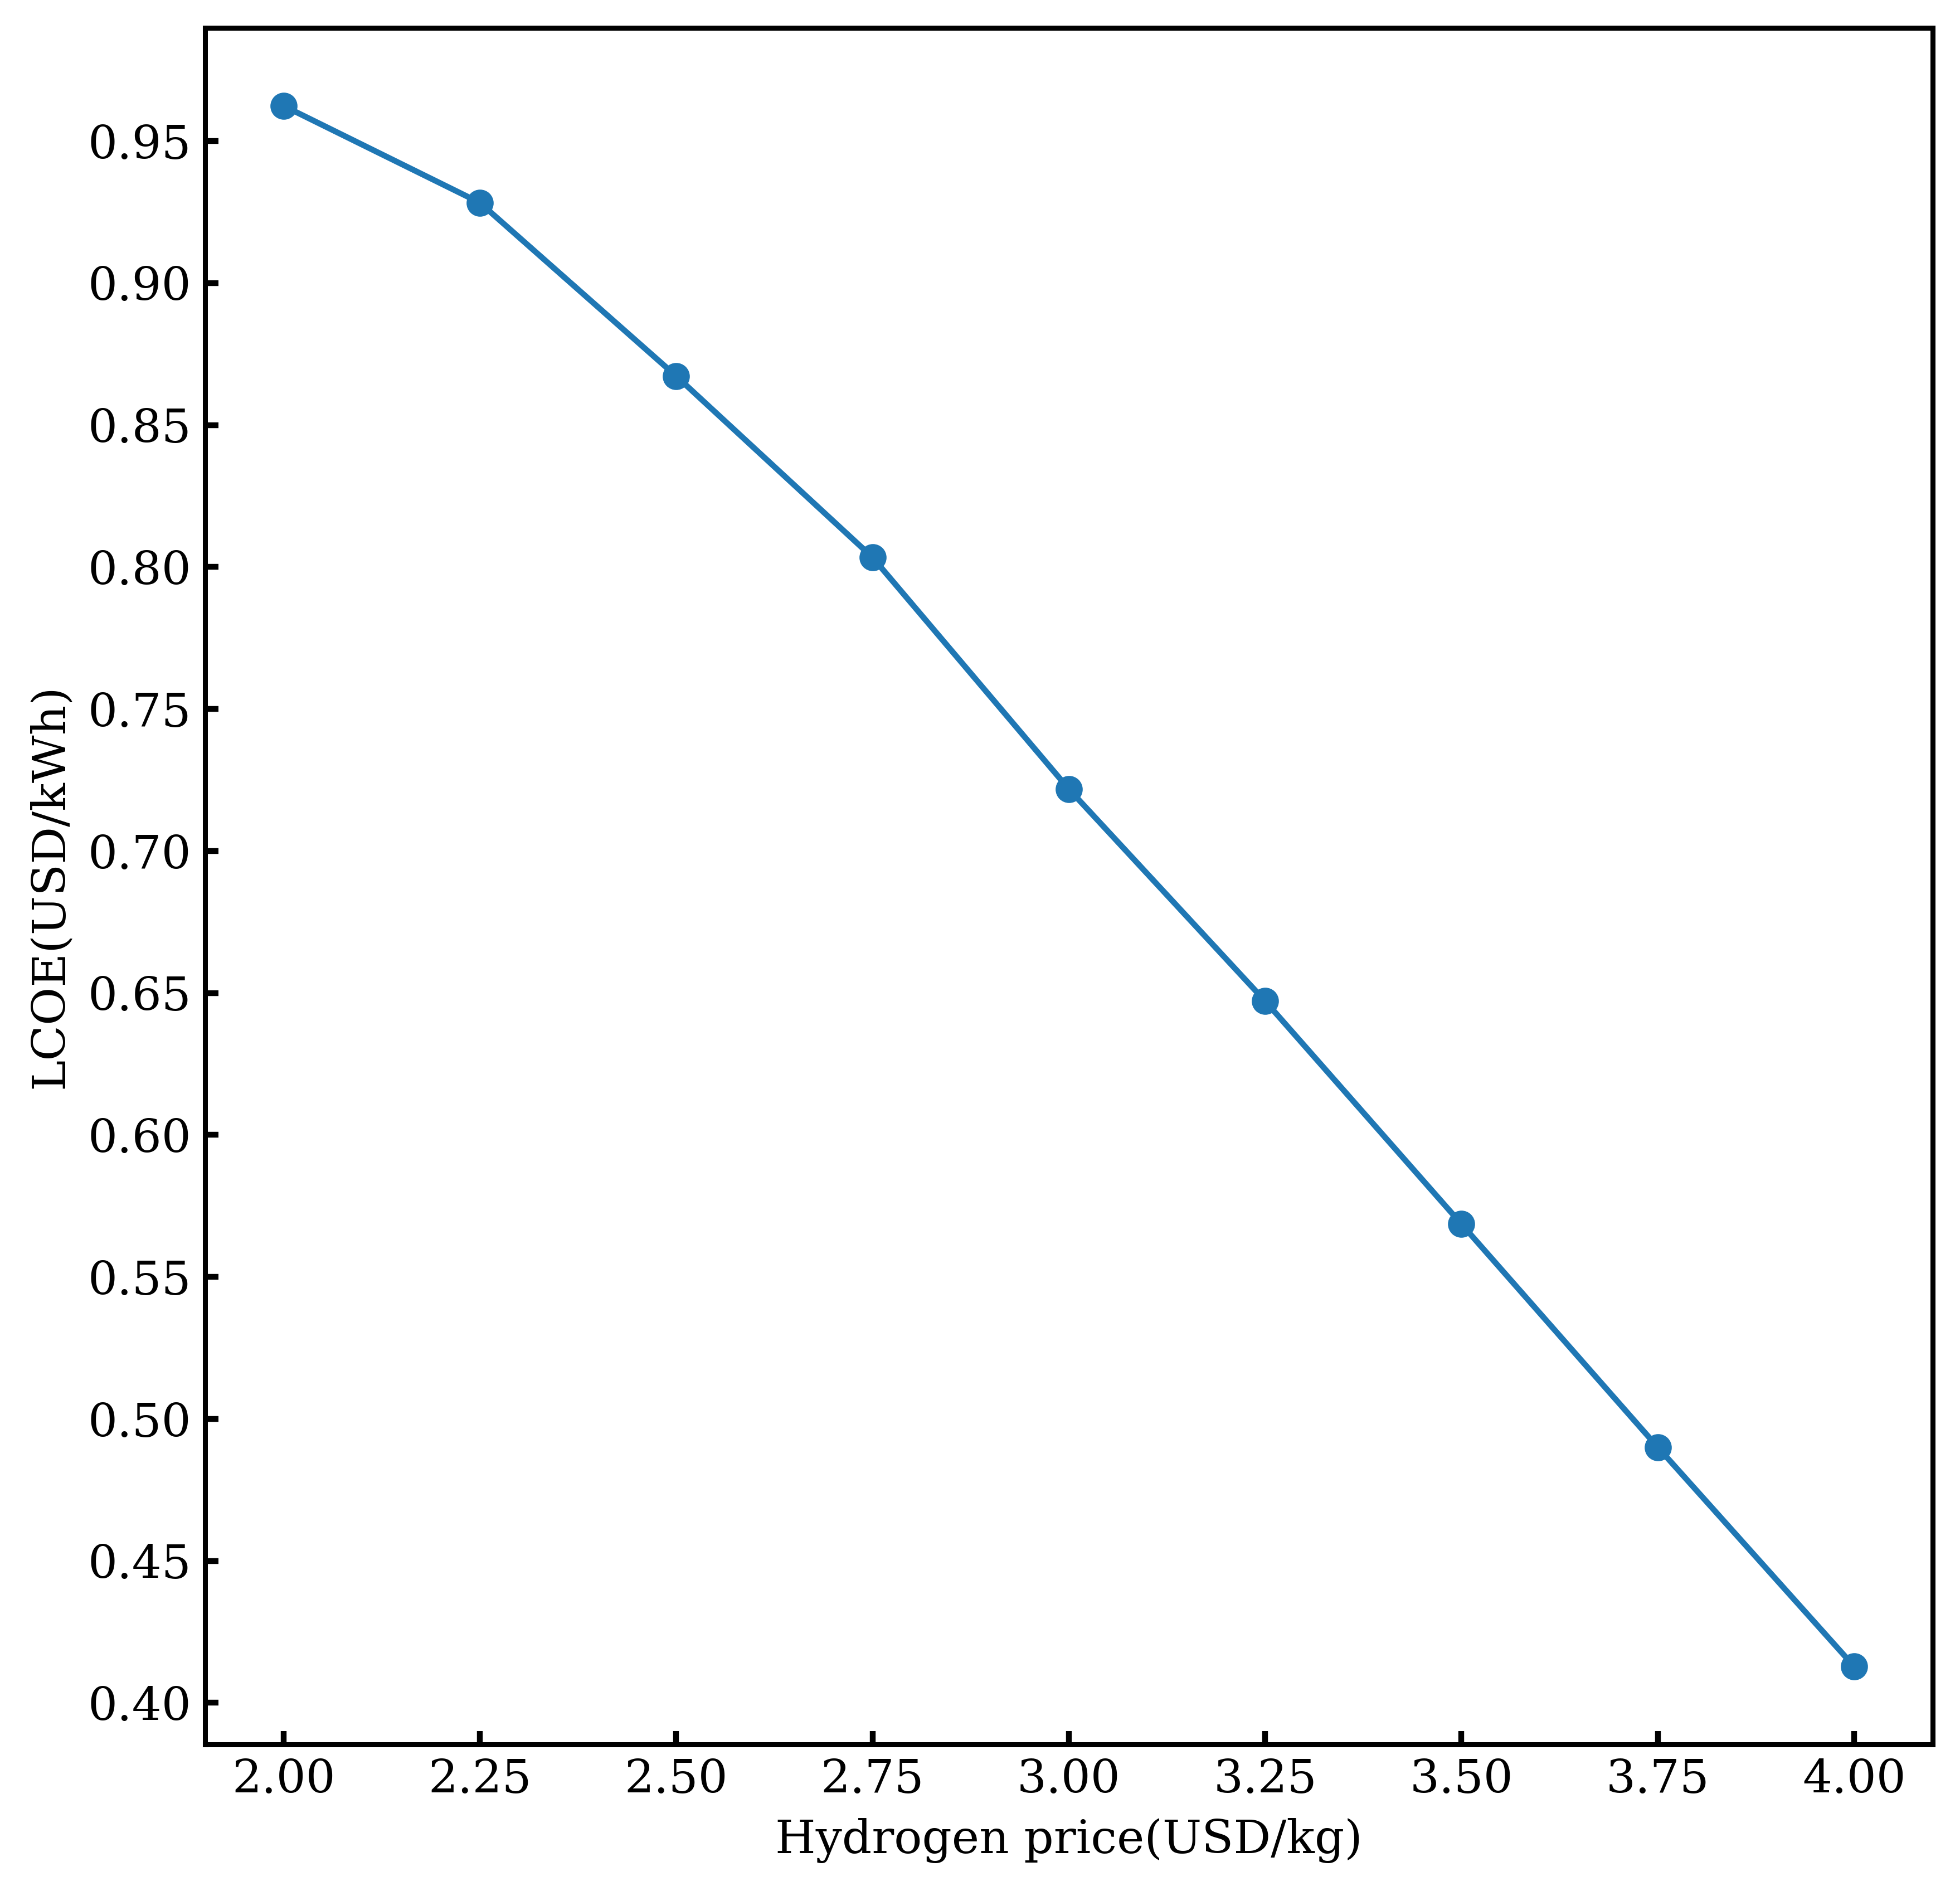

In [ ]:
x = [2, 2.25, 2.50, 2.75, 3.0, 3.25, 3.50, 3.75, 4.0]
y=[results_p2h2p2.F+inv_p2h2p_lcoe, results_p2h2p2_25.F+inv_p2h2p_lcoe,
   results_p2h2p2_50.F+inv_p2h2p_lcoe,results_p2h2p2_75.F+inv_p2h2p_lcoe,
   results_p2h2p3.F+inv_p2h2p_lcoe,results_p2h2p3_25.F+inv_p2h2p_lcoe,
   results_p2h2p3_50.F+inv_p2h2p_lcoe,results_p2h2p3_75.F+inv_p2h2p_lcoe,
   results_p2h2p4.F+inv_p2h2p_lcoe]
plt.figure(figsize=(8,8), dpi=500)
plt.subplot(1,1,1)
set_plot_style(plt.gca())
plt.plot(x,y)
plt.scatter(x,y)
plt.yticks(np.arange(0.4, 1, 0.05))
plt.xlabel("Hydrogen price(USD/kg)")
plt.ylabel("LCOE(USD/kWh)")
plt.savefig('p2h2p_sensitivity.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

x = np.array(x).reshape(-1, 1) # Reshape x for scikit-learn
y = np.array(y)


# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_predictions = linear_model.predict(x)

# Polynomial Regression (2nd degree)
polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
polynomial_model = LinearRegression()
polynomial_model.fit(x_poly, y)
polynomial_predictions = polynomial_model.predict(x_poly)

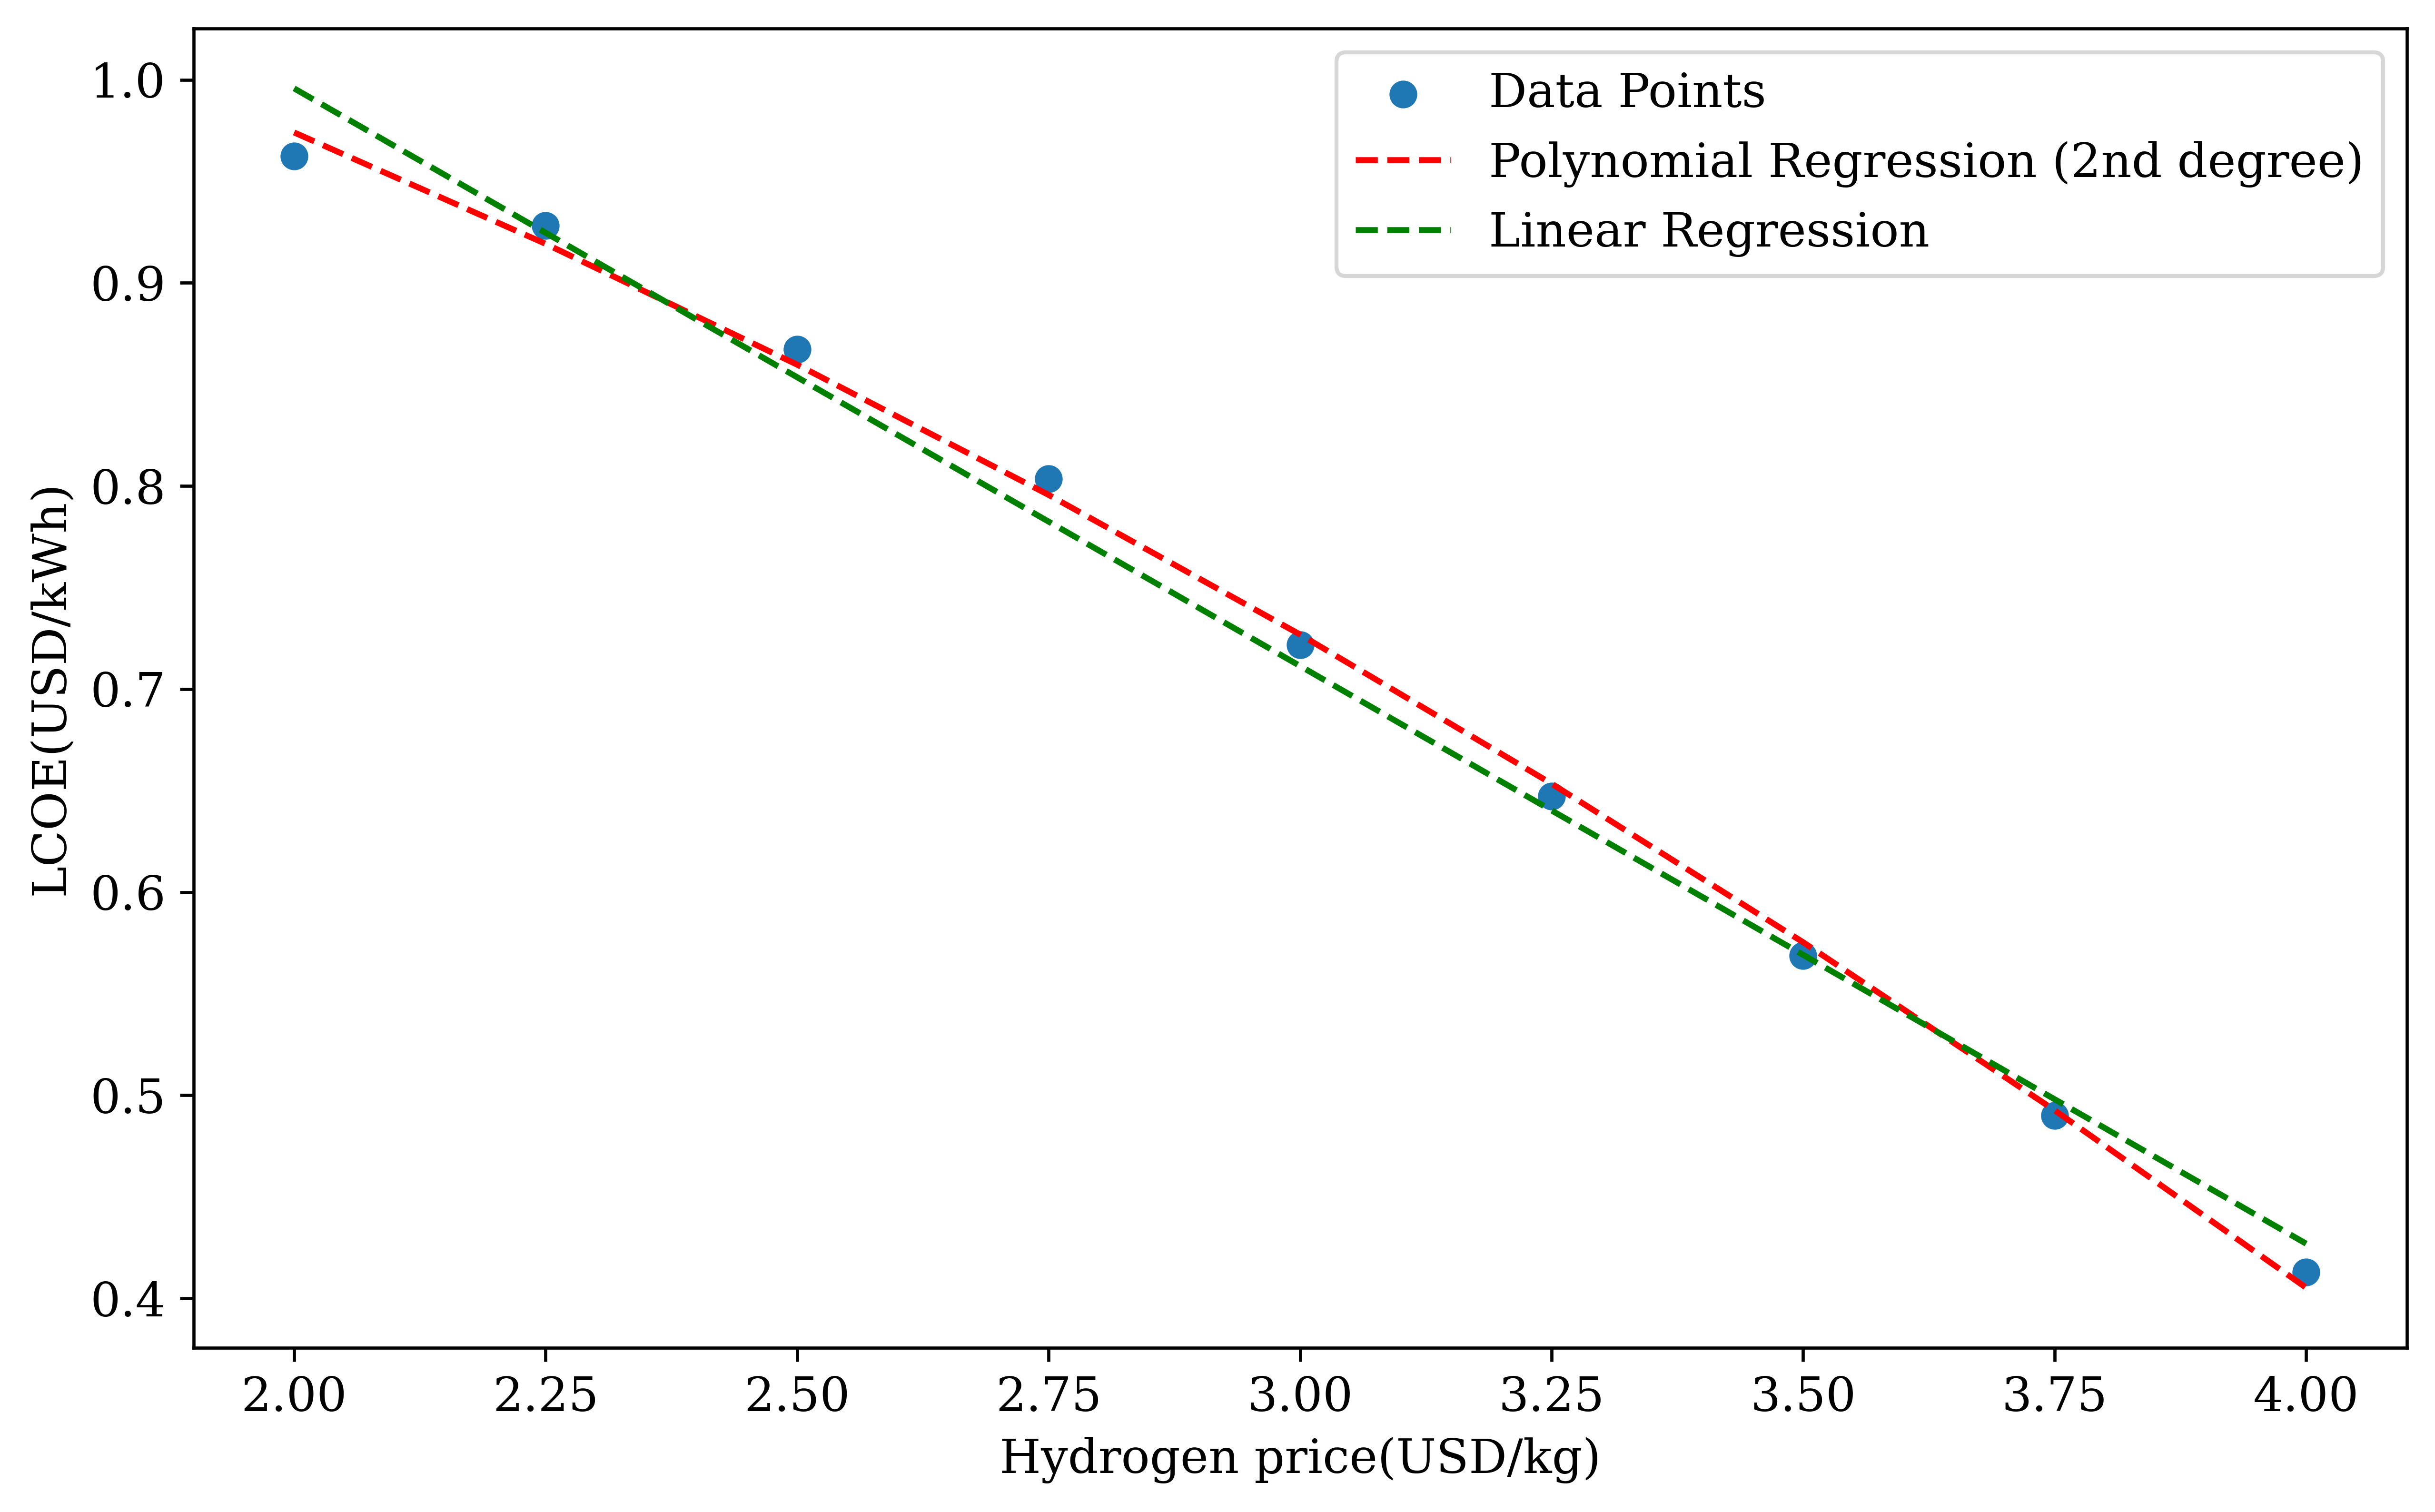

In [ ]:
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(x, y, label="Data Points")
plt.plot(x, polynomial_predictions, color='red', ls="--", label="Polynomial Regression (2nd degree)")
plt.plot(x, linear_predictions, color='green', ls="--", label="Linear Regression")
plt.xlabel("Hydrogen price(USD/kg)")
plt.ylabel("LCOE(USD/kWh)")
plt.legend()
plt.savefig('sensitivity_both_fit.png')
plt.show()

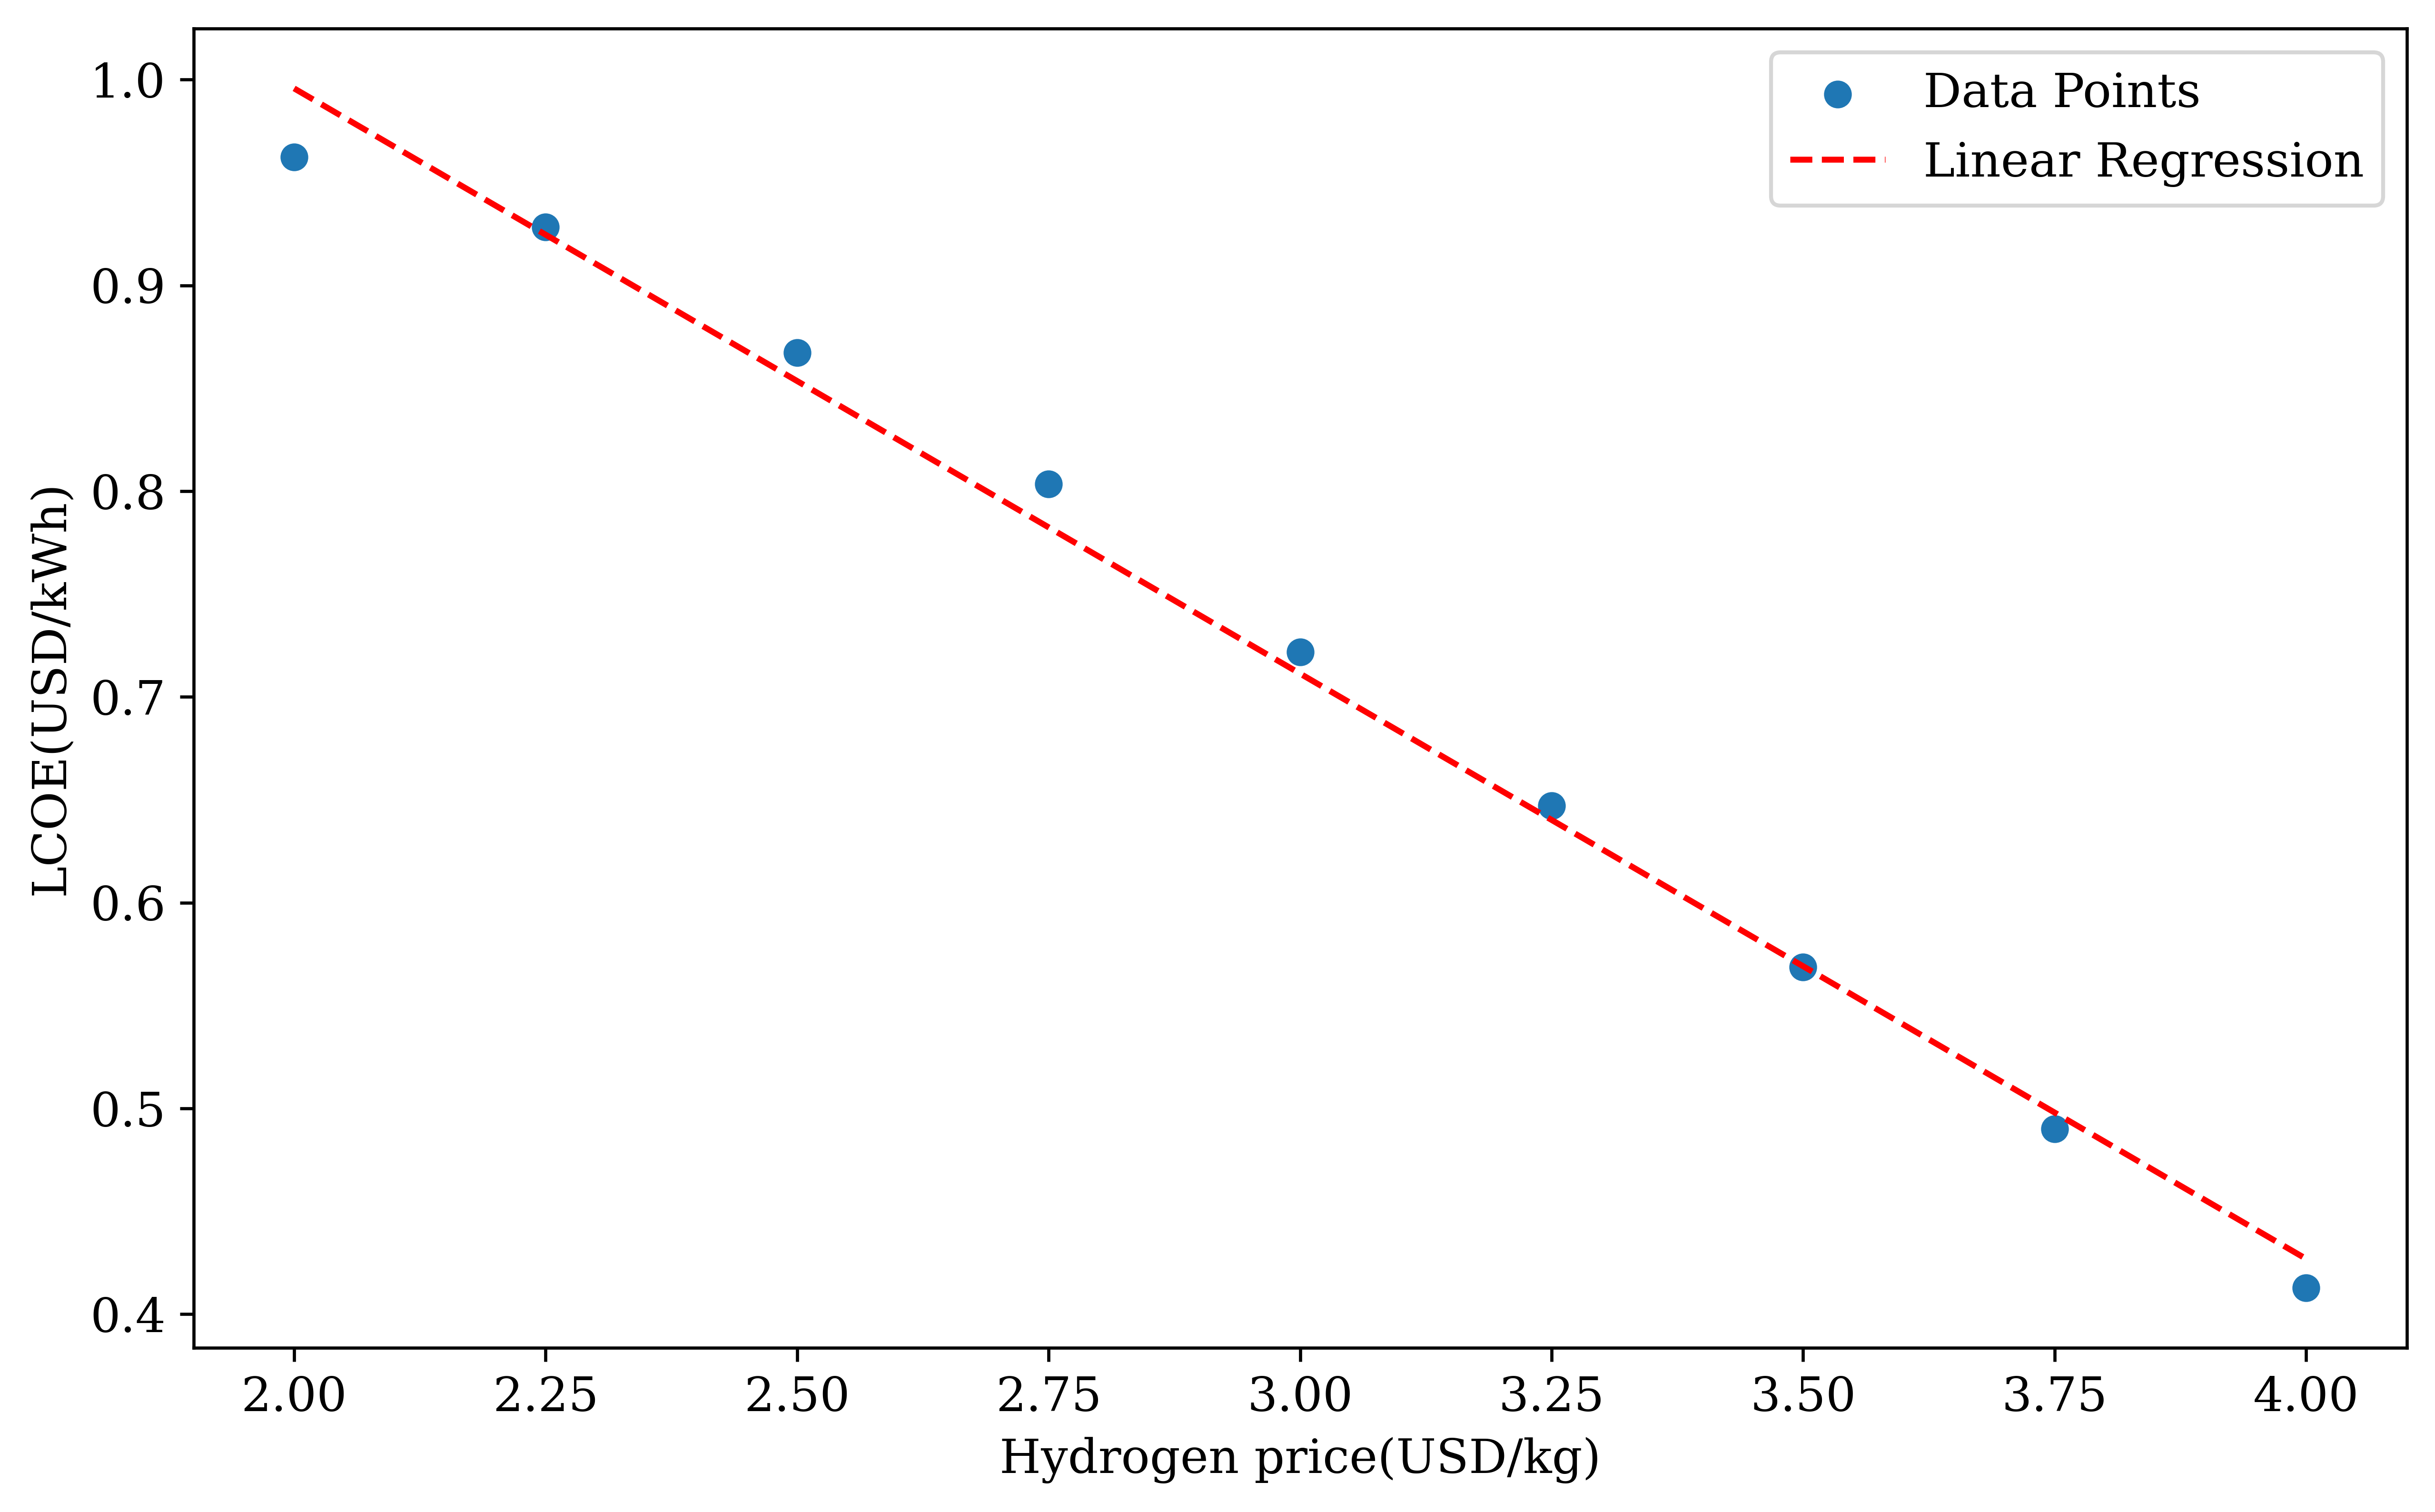

Linear Regression R^2: 0.9928876625745204


In [ ]:
# Plotting
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(x, y, label="Data Points")
plt.plot(x, linear_predictions, color='red', ls="--", label="Linear Regression")
plt.xlabel("Hydrogen price(USD/kg)")
plt.ylabel("LCOE(USD/kWh)")
plt.legend()
plt.savefig('sensitivity_linear_fit.png')
plt.show()

linear_predictions = linear_model.predict(x)
linear_r2 = r2_score(y, linear_predictions)
print(f"Linear Regression R^2: {linear_r2}")

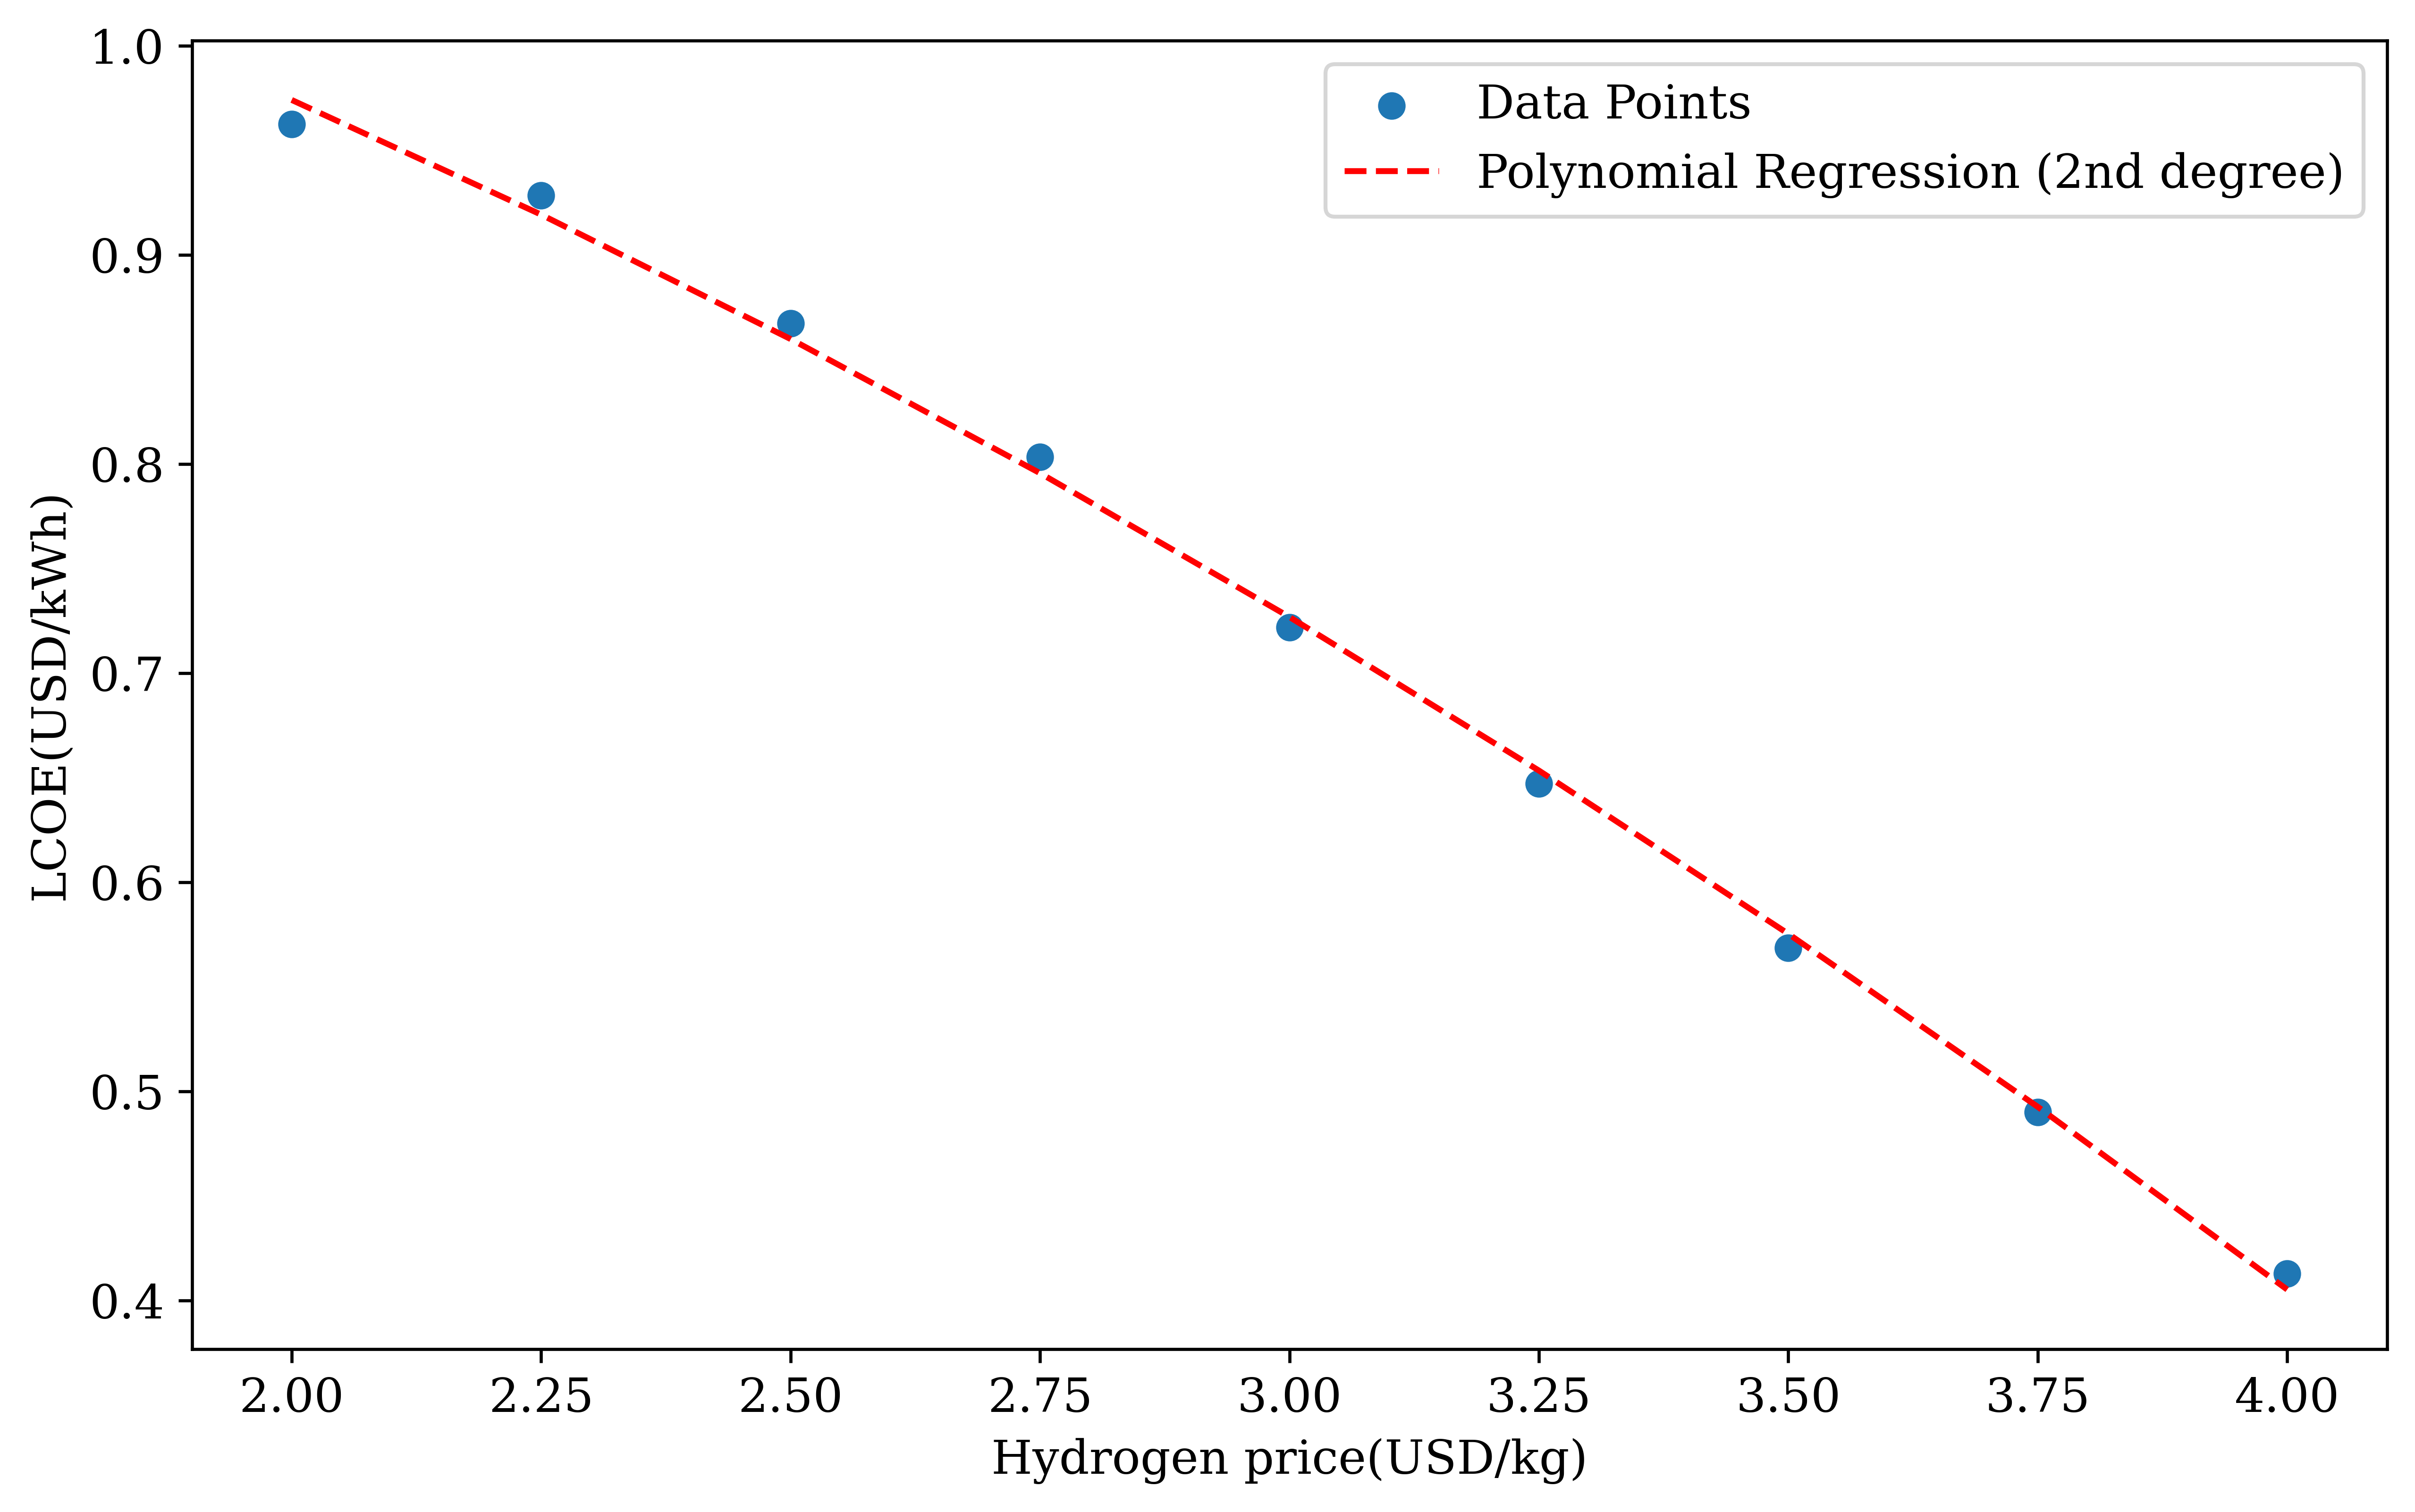

Polynomial Regression R^2: 0.9983327514599463


In [ ]:
# Plotting
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(x, y, label="Data Points")
plt.plot(x, polynomial_predictions, color='red', ls="--", label="Polynomial Regression (2nd degree)")
plt.xlabel("Hydrogen price(USD/kg)")
plt.ylabel("LCOE(USD/kWh)")
plt.legend()
plt.savefig('sensitivity_polynomial_fit.png')
plt.show()

polynomial_predictions = polynomial_model.predict(x_poly)
polynomial_r2 = r2_score(y, polynomial_predictions)
print(f"Polynomial Regression R^2: {polynomial_r2}")

In [ ]:
print("Linear Regression Equation:")
print(f"LCOE = {linear_model.coef_[0][0]:.4f} * (Hydrogen Price) + {linear_model.intercept_[0]:.4f}")

print("\nPolynomial Regression Equation (2nd degree):")
print(f"LCOE = {polynomial_model.coef_[0][2]:.4f} * (Hydrogen Price)^2 + {polynomial_model.coef_[0][1]:.4f} * (Hydrogen Price) + {polynomial_model.intercept_[0]:.4f}")

Linear Regression Equation:
LCOE = -0.2844 * (Hydrogen Price) + 1.5646

Polynomial Regression Equation (2nd degree):
LCOE = -0.0372 * (Hydrogen Price)^2 + -0.0613 * (Hydrogen Price) + 1.2454
